<a href="https://colab.research.google.com/github/prs-016/bsbproject/blob/main/baseball_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install statsmodels
!pip install pybaseball
!pip install xgboost
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.4 MB/s eta 0:00:00


In [ ]:
from pybaseball import statcast
from pybaseball import statcast_fielding
from pybaseball import plotting




In [ ]:
import numpy as np

BALL = 0.145
PLATE_HALF_WIDTH = 0.83
df = statcast(start_dt='2024-03-28', end_dt='2025-09-28')

# Horizontal distance to nearest vertical edge of strike zone
df['dist_x'] = abs(abs(df['plate_x']) - PLATE_HALF_WIDTH)

# Vertical distance to lower and upper boundaries
df['dist_low'] = abs(df['plate_z'] - df['sz_bot'])
df['dist_high'] = abs(df['sz_top'] - df['plate_z'])

# Minimum distance to ANY edge
df['edge_dist'] = df[['dist_x', 'dist_low', 'dist_high']].min(axis=1)

# Filter: within 1 ball (0.145 ft) of the strike zone boundary
shadow_band = df[df['edge_dist'] <= BALL]
df.columns
len(df.columns)


This is a large query, it may take a moment to complete


/usr/local/lib/python3.12/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


  0%|          | 0/431 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.12/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.12/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = 

122

In [ ]:
def isCorrectCall(row):
    x = row['plate_x']
    z = row['plate_z']
    sz_bot = row['sz_bot']
    sz_top = row['sz_top']
    call = row['description']  # 'ball' or 'called_strike'

    # True location: inside strike zone?
    in_zone = (abs(x) <= PLATE_HALF_WIDTH) and (sz_bot <= z <= sz_top)

    # Correct strike?
    if call == 'called_strike':
        return in_zone

    # Correct ball?
    if call == 'ball':
        return not in_zone

In [ ]:
sb_sorted = shadow_band[['batter', 'pitcher', 'events', 'description','pitch_name','zone', 'type', 'balls','strikes', 'on_3b', 'on_2b', 'on_1b','plate_x', 'plate_z','sz_top', 'sz_bot', 'outs_when_up', 'inning', 'inning_topbot','bat_win_exp', 'delta_run_exp', 'delta_home_win_exp']]
sb_filtered = sb_sorted[sb_sorted["description"].isin(["called_strike", "ball"])]
sb_filtered['delta_bat_win_exp'] = sb_filtered['delta_home_win_exp'] * (
    sb_filtered['inning_topbot'].map({'Bot': 1, 'Top': -1})
)
sb_filtered = sb_filtered.assign(
    isCorrectCall=lambda d: d.apply(isCorrectCall, axis=1)
)

/tmp/ipython-input-4095518946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sb_filtered['delta_bat_win_exp'] = sb_filtered['delta_home_win_exp'] * (


In [ ]:
def miss_direction(row, edge=0.15):
    px = row['plate_x']
    pz = row['plate_z']
    top = row['sz_top']
    bot = row['sz_bot']

    # strike zone width
    left = -0.708
    right = 0.708

    # ---------------------------
    # inside strike zone
    # ---------------------------
    if left <= px <= right and bot <= pz <= top:

        horiz = ""
        vert = ""

        # close to horizontal edges
        if px > right - edge:
            horiz = "right"
        elif px < left + edge:
            horiz = "left"

        # close to vertical edges
        if pz > top - edge:
            vert = "up"
        elif pz < bot + edge:
            vert = "down"

        if vert and horiz:
            return f"{vert} {horiz}".strip()
        if vert:
            return vert
        if horiz:
            return horiz

        return "middle"

    # ---------------------------
    # outside zone
    # ---------------------------
    horiz = ""
    vert = ""

    if px > right:
        horiz = "right"
    elif px < left:
        horiz = "left"

    if pz > top:
        vert = "up"
    elif pz < bot:
        vert = "down"

    if vert and horiz:
        return f"{vert} {horiz}".strip()

    return vert or horiz or "middle"

sb_filtered["miss_location"] = sb_filtered.apply(miss_direction, axis=1)
categories = [
    "middle",
    "up",
    "up right",
    "right",
    "down right",
    "down",
    "down left",
    "left",
    "up left"
]

mapping = {cat:i for i,cat in enumerate(categories)}

sb_filtered["miss_code"] = sb_filtered["miss_location"].map(mapping)


In [ ]:
df_final = sb_filtered.drop(columns=[
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
    'delta_home_win_exp',
    'batter',
    'pitcher',
    'type',
    "zone"
])

runner_cols = ['on_1b', 'on_2b', 'on_3b']
df_final[runner_cols] = df_final[runner_cols].notna().astype(int)
df_final.sort_values('delta_bat_win_exp', ascending= False)

df_final["count"] = df_final.apply(
    lambda row: f"{row['balls']:01d}{row['strikes']:01d}",
    axis=1
)
df_final.drop(columns=["balls", "strikes"], inplace=True)

df_final["runners_on_binary"] = (
    df_final["on_1b"].astype(str) +
    df_final["on_2b"].astype(str) +
    df_final["on_3b"].astype(str)
)
df_final.drop(columns=["on_1b", "on_2b", "on_3b"], inplace=True)


pitch_map = {
    "4-Seam Fastball": 0,
    "2-Seam Fastball": 1,
    "Slider": 2,
    "Changeup": 3,
    "Cutter": 4,
    "Sinker": 5,
    "Split-Finger": 6,
    "Splitter": 7,
    "Two-Seam Fastball": 8,
    "Knuckleball": 9,
    "Curveball": 10,
    "Pitchout": 11,
    "Eephus": 12,
    "Screwball": 13,
    "Forkball": 14,
    "Sweeper": 15,
    "Knuckle Curve": 16,
    "Slurve": 17,
    "Slow Curve": 18,
    "Other": 19,


}

df_final["pitch_name_code"] = df_final["pitch_name"].map(pitch_map)
df_final = df_final[~df_final['description'].str.contains('ball', case=False, na=False)]
df_final.columns


Index(['events', 'description', 'pitch_name', 'outs_when_up', 'inning',
       'inning_topbot', 'bat_win_exp', 'delta_run_exp', 'delta_bat_win_exp',
       'isCorrectCall', 'miss_location', 'miss_code', 'count',
       'runners_on_binary', 'pitch_name_code'],
      dtype='object')

In [ ]:
print(f"The final dataset `df_final` contains {len(df_final)} rows.")

The final dataset `df_final` contains 83160 rows.


In [ ]:
df_pitchAccuracy = df_final
df_pitchAccuracy.groupby("pitch_name")["isCorrectCall"].mean().round(decimals=2)

,isCorrectCall
pitch_name,
4-Seam Fastball,0.65
Changeup,0.60
Curveball,0.63
Cutter,0.64
Eephus,0.51
Forkball,0.67
Knuckle Curve,0.62
Knuckleball,0.69
Other,0.51


In [ ]:
df_zoneAcc = df_final
df_final.groupby("miss_code")["isCorrectCall"].mean().round(decimals=2)

,isCorrectCall
miss_code,
1,0.60
2,0.67
3,0.66
4,0.63
5,0.56
6,0.63
7,0.70
8,0.71


In [ ]:
df_countAcc = df_final
df_countAcc.groupby("count")["isCorrectCall"].mean().round(decimals = 2)

,isCorrectCall
count,
00,0.65
01,0.65
02,0.66
10,0.63
11,0.63
12,0.63
20,0.61
21,0.60
22,0.61


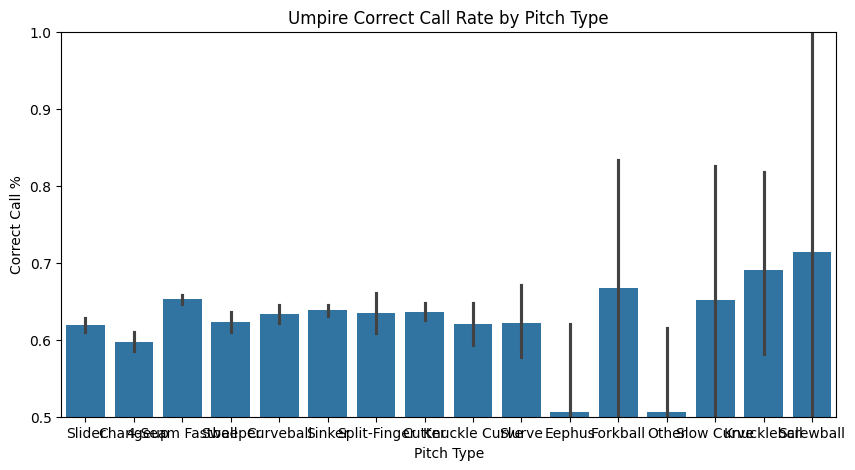

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_final,
    x="pitch_name",
    y="isCorrectCall",
    estimator="mean"
)
plt.title("Umpire Correct Call Rate by Pitch Type")
plt.ylabel("Correct Call %")
plt.xlabel("Pitch Type")
plt.ylim(0.5, 1)
plt.show()


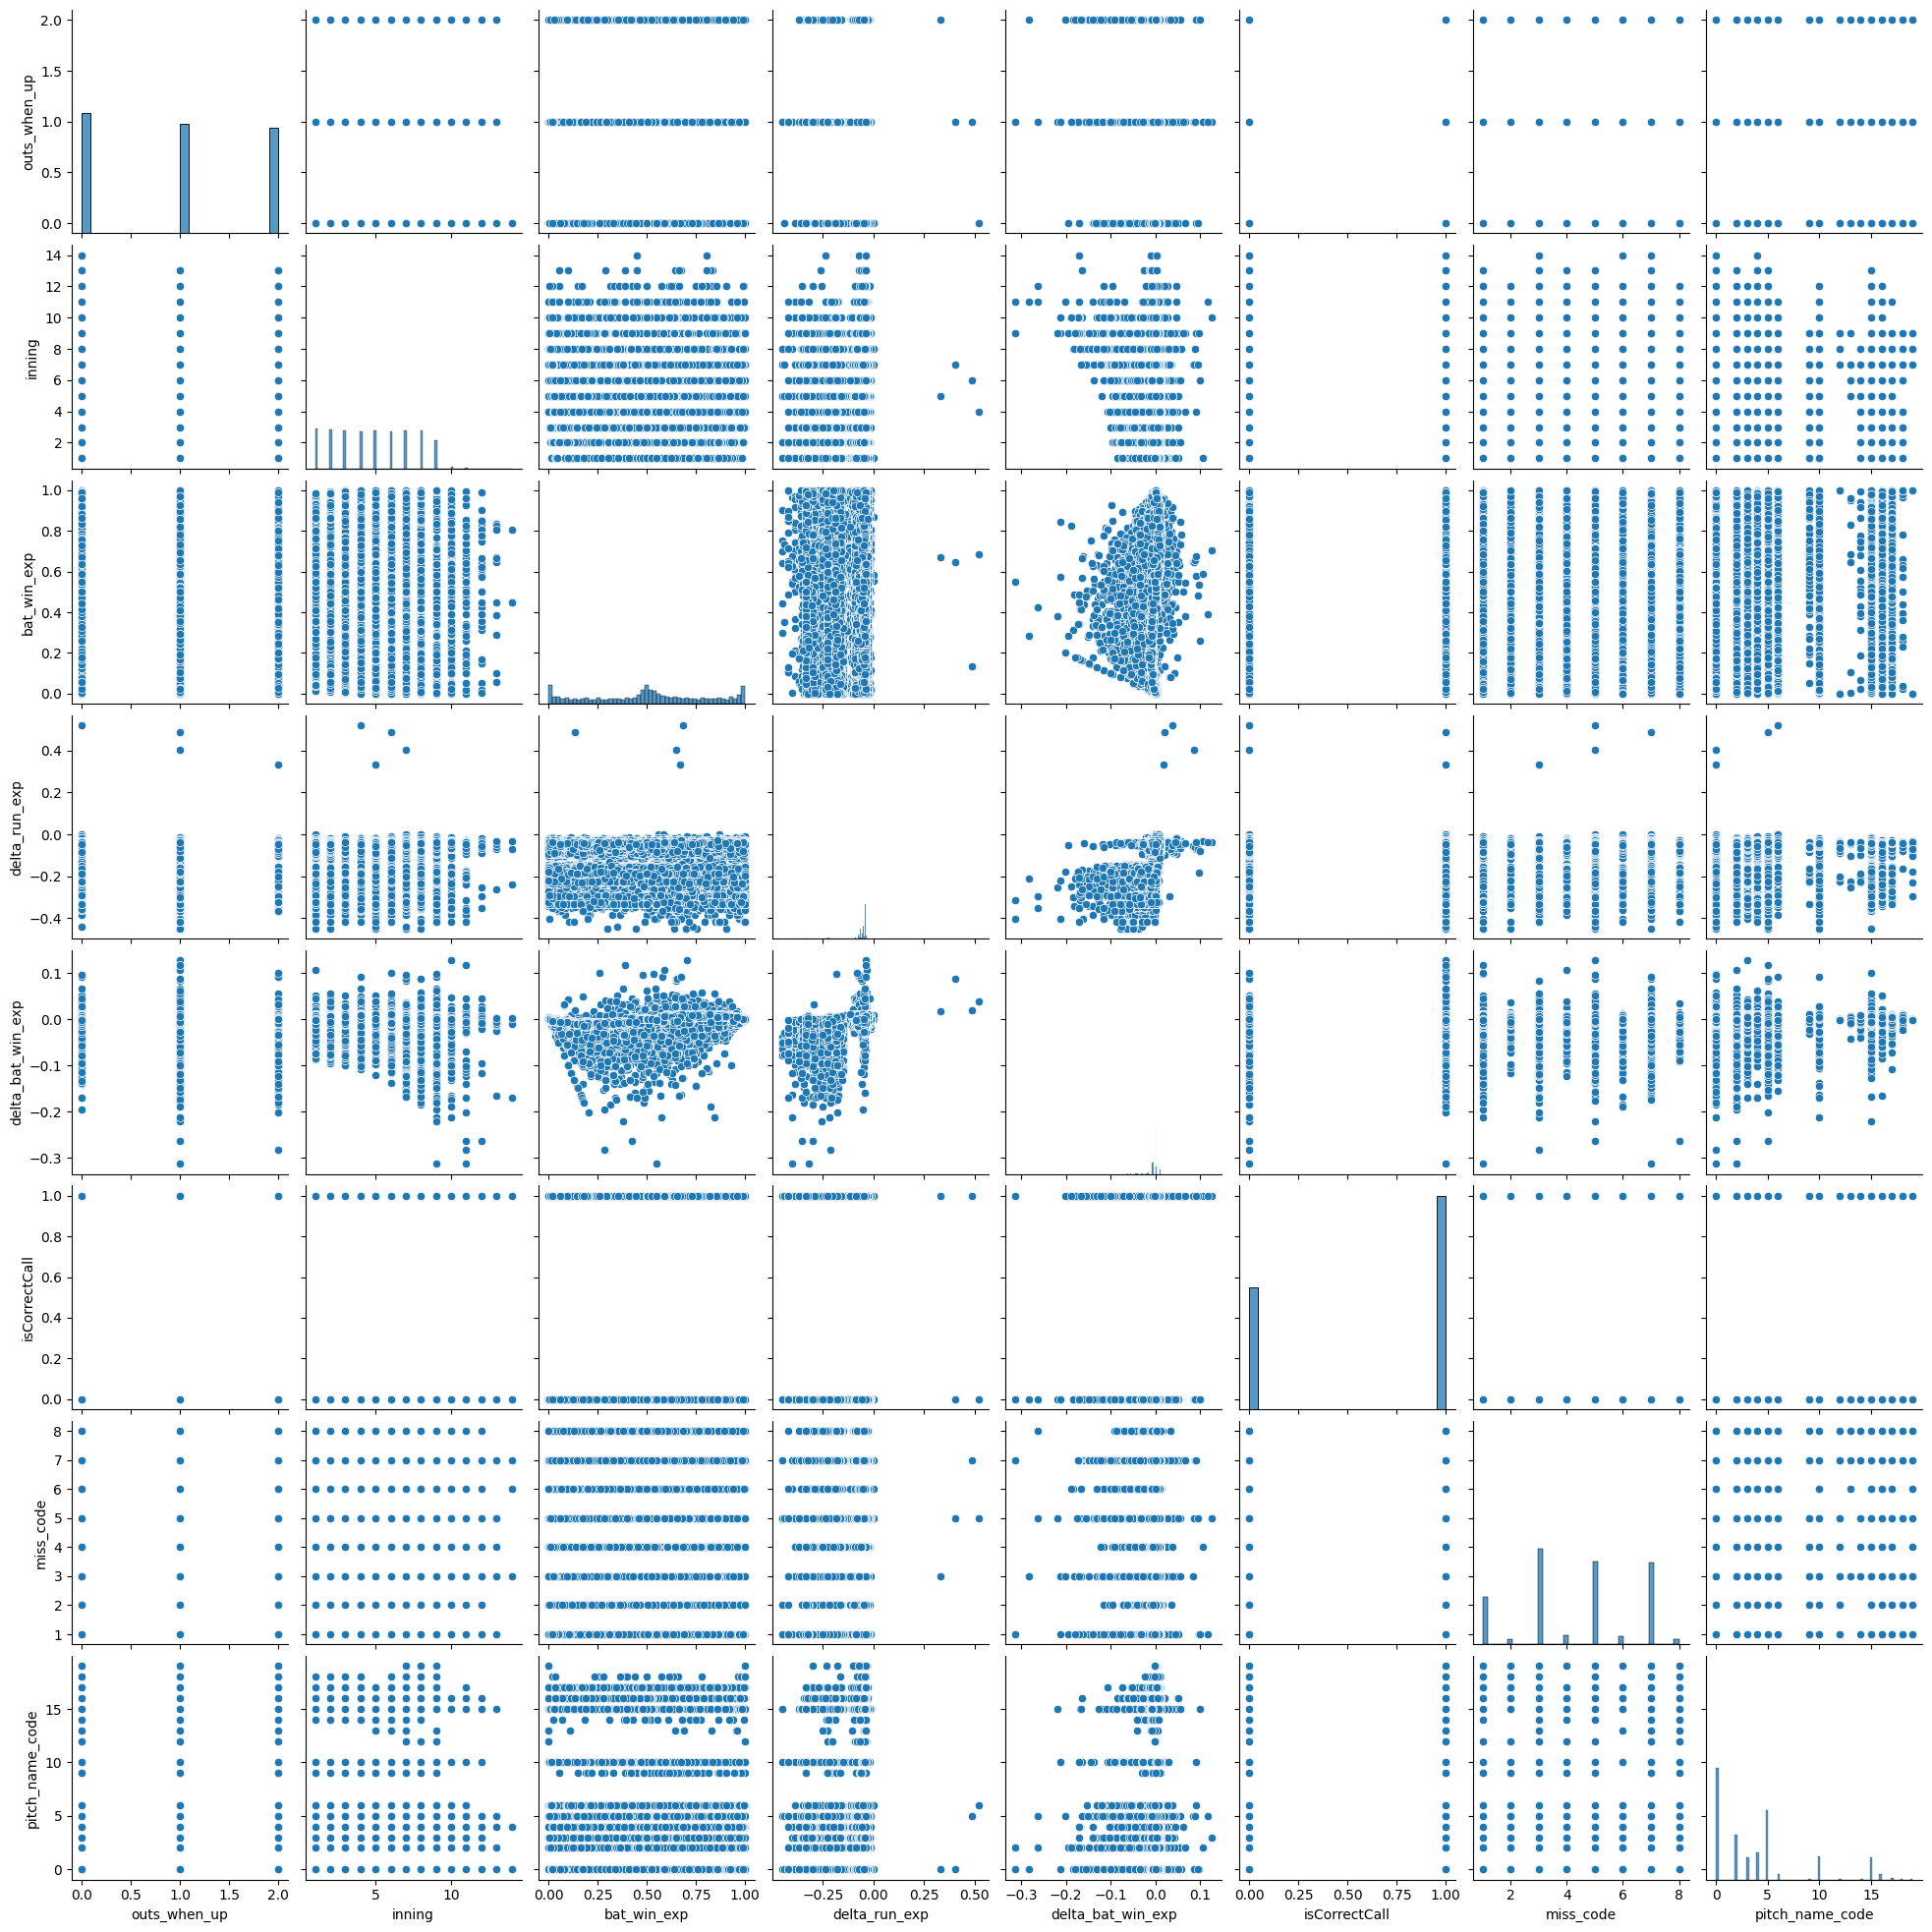

In [ ]:
df_final_reset = df_final.reset_index(drop=True)
sns.pairplot(df_final_reset)
plt.show()

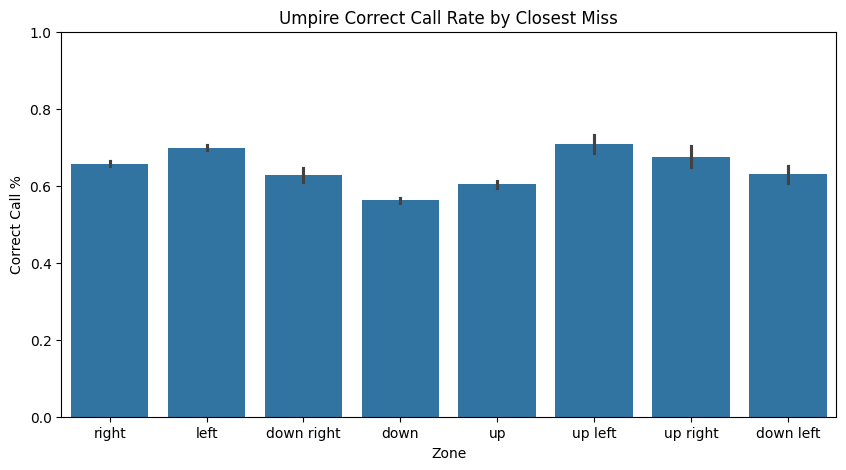

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_final,
    x="miss_location",
    y="isCorrectCall",
    estimator="mean"
)
plt.title("Umpire Correct Call Rate by Closest Miss")
plt.ylabel("Correct Call %")
plt.xlabel("Zone")
plt.ylim(0, 1)
plt.show()


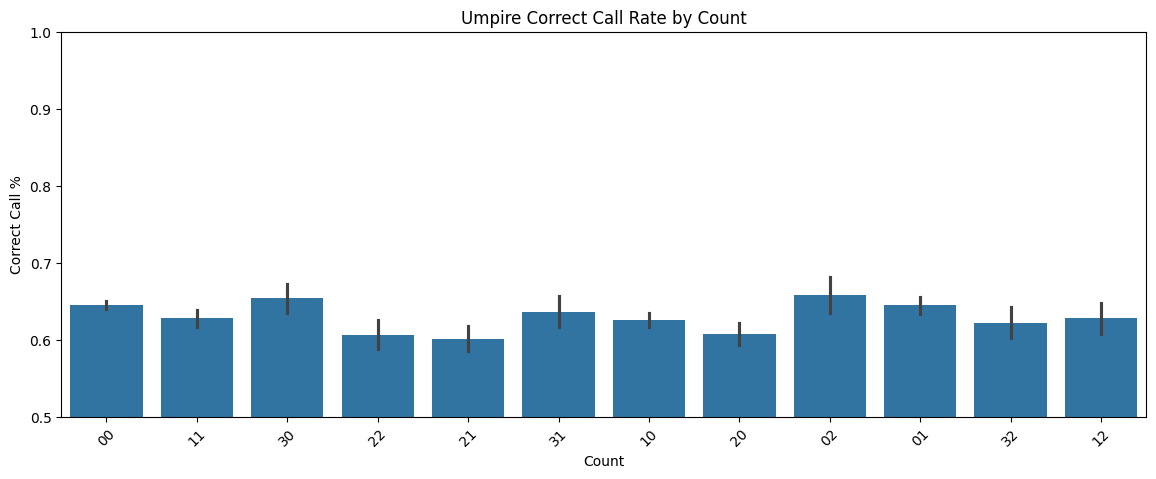

In [ ]:
plt.figure(figsize=(14,5))
sns.barplot(
    data=df_final,
    x="count",
    y="isCorrectCall",
    estimator="mean"
)
plt.title("Umpire Correct Call Rate by Count")
plt.ylabel("Correct Call %")
plt.xlabel("Count")
plt.ylim(0.5, 1)
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

df = df_final.copy()

# -------------------------------------------------
# Extract balls/strikes from count (32 -> 3 balls, 2 strikes)
# -------------------------------------------------
df['count'] = df['count'].astype(str).str.zfill(2)
df['balls'] = df['count'].str[0].astype(int)
df['strikes'] = df['count'].str[1].astype(int)

# -------------------------------------------------
# Extract runners from existing runner code
# runners already formatted as 3 digits
# -------------------------------------------------
df['runner_on_1B'] = df['runners_on_binary'].str[0].astype(int)
df['runner_on_2B'] = df['runners_on_binary'].str[1].astype(int)
df['runner_on_3B'] = df['runners_on_binary'].str[2].astype(int)

# -------------------------------------------------
# FEATURES
# -------------------------------------------------
features = [
    'pitch_name_code',
    'miss_code',
    'balls', 'strikes',
    'outs_when_up',
    'runner_on_1B',
    'runner_on_2B',
    'runner_on_3B'
]

X = df[features]
y = 1 - df_final["isCorrectCall"]

# -------------------------------------------------
# TRAIN / TEST SPLIT
# -------------------------------------------------
# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: split the 20% into 10% test and 10% validation
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# -------------------------------------------------
# XGBoost Model
# -------------------------------------------------
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='logloss',
    scale_pos_weight = (y==0).sum() / (y==1).sum()
)

model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:,1]
preds = (probs > 0.25).astype(int)

# -------------------------------------------------
# EVALUATION
# -------------------------------------------------
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


Accuracy: 0.36664261664261666
              precision    recall  f1-score   support

           0       0.71      0.00      0.00      5270
           1       0.37      1.00      0.54      3046

    accuracy                           0.37      8316
   macro avg       0.54      0.50      0.27      8316
weighted avg       0.59      0.37      0.20      8316



In [ ]:
# separate inputs
X = df[features]
y = df['isCorrectCall']
delta = df['delta_bat_win_exp']

# split
X_train, X_temp, y_train, y_temp, delta_train, delta_temp = train_test_split(
    X, y, delta, test_size=0.2, stratify=y, random_state=42
)

X_test, X_val, y_test, y_val, delta_test, delta_val = train_test_split(
    X_temp, y_temp, delta_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# predictions
df_val = X_val.copy()
df_val['P_success'] = model.predict_proba(X_val)[:,1]
df_val['IsCorrectCall'] = y_val.values
df_val['delta_bat_win_exp'] = delta_val.values

COST_FAIL = .05 # you can tune this later

df_val['EV'] = (
    df_val['P_success'] * -1 * df_val['delta_bat_win_exp']
    - (1 - df_val['P_success']) * COST_FAIL
)

df_val['Challenge'] = df_val['EV'] > 0

df_val.groupby('Challenge')['IsCorrectCall'].mean()



,IsCorrectCall
Challenge,
False,0.636486
True,0.575758


In [ ]:
mean_EV_challenges = df_val.loc[df_val['Challenge'], 'EV'].mean()
print("Mean EV for recommended challenges:", mean_EV_challenges)

Mean EV for recommended challenges: 0.016961931403726337


In [ ]:
df_val['Challenge'].value_counts()

,count
Challenge,
False,8184
True,132


In [ ]:
mean_p_success_challenges = df_val.loc[df_val['Challenge'], 'P_success'].mean()
print("Average P_success for recommended challenges:", mean_p_success_challenges)

Average P_success for recommended challenges: 0.562138


In [ ]:
mean_p_success_no_challenge = df_val.loc[~df_val['Challenge'], 'P_success'].mean()
print("Average P_success for non-challenged plays:", mean_p_success_no_challenge)

Average P_success for non-challenged plays: 0.49730968


In [ ]:
import pandas as pd

# Get raw feature importances
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})

# Sort descending
importance = importance.sort_values(by='importance', ascending=False)
print(importance)

           feature  importance
1        miss_code    0.367913
0  pitch_name_code    0.110277
2            balls    0.097111
3          strikes    0.088410
5     runner_on_1B    0.087657
4     outs_when_up    0.084596
6     runner_on_2B    0.082433
7     runner_on_3B    0.081603


In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)
print(perm_df)

           feature  importance_mean  importance_std
5     runner_on_1B        -0.001647        0.000693
4     outs_when_up        -0.002213        0.002305
6     runner_on_2B        -0.003379        0.001410
3          strikes        -0.004906        0.002018
7     runner_on_3B        -0.005026        0.001612
2            balls        -0.009644        0.002338
0  pitch_name_code        -0.012338        0.002679
1        miss_code        -0.046441        0.003977


<Figure size 1000x600 with 0 Axes>

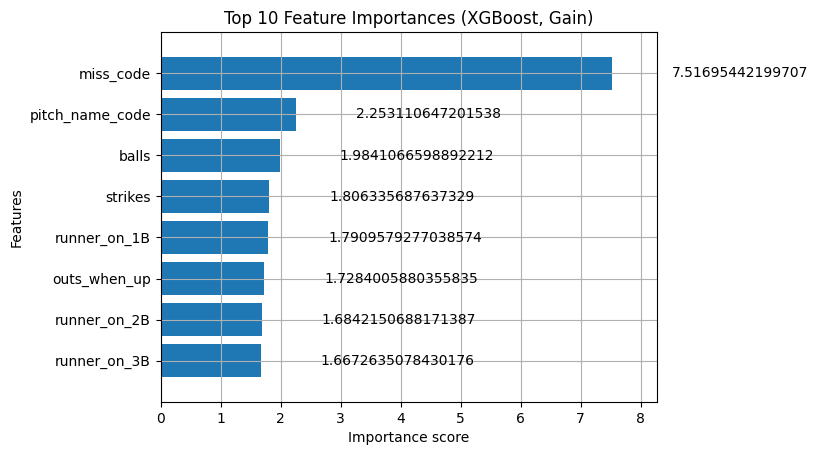

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import plot_importance

# Option 1: Using XGBoost built-in plot
plt.figure(figsize=(10,6))
plot_importance(model, importance_type='gain', max_num_features=10, height=0.8)
plt.title("Top 10 Feature Importances (XGBoost, Gain)")
plt.show()


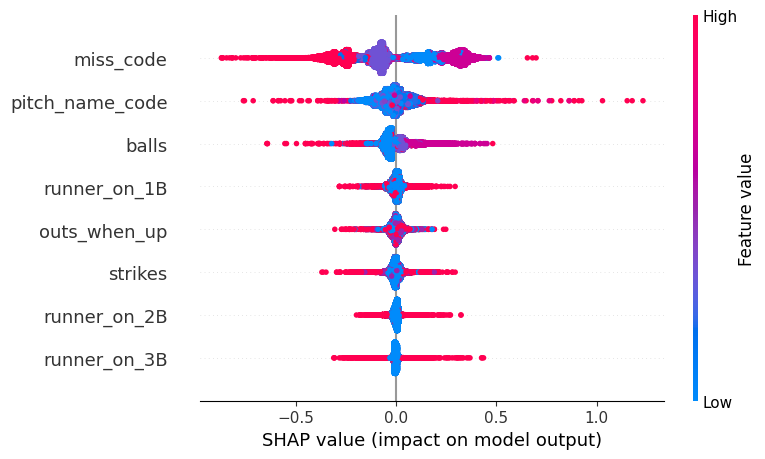

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

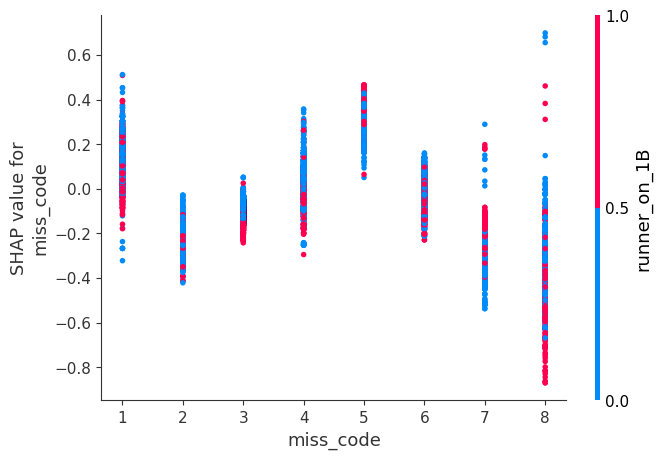

In [ ]:
shap.dependence_plot("miss_code", shap_values, X_train)

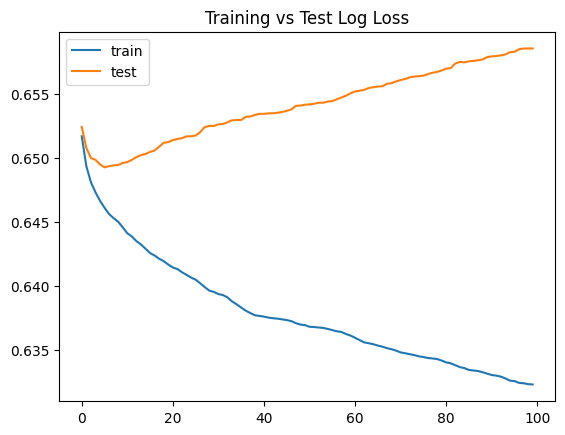

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(eval_metric="logloss")
model.fit(
    X_train, y_train.astype(int),
    eval_set=[(X_train, y_train.astype(int)), (X_test, y_test.astype(int))],
    verbose=False
)

results = model.evals_result()

plt.plot(results["validation_0"]["logloss"], label="train")
plt.plot(results["validation_1"]["logloss"], label="test")
plt.legend()
plt.title("Training vs Test Log Loss")
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as logit

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, stratify=y, random_state=42
)

model = LogisticRegression(max_iter=2000, class_weight="balanced")
model.fit(X_train, y_train)

preds = model.predict(X_test)

df_val_logit = df_final.loc[X_val.index].copy()
df_val_logit["P_success_logit"] = logit.predict_proba(X_val_poly)[:, 1]

# ---------------------------------------------------
# 5. Compute EV
# ---------------------------------------------------
df_val_logit["EV_logit"] = df_val_logit["P_success_logit"] * df_val_logit["delta_bat_win_exp"]

# ---------------------------------------------------
# 6. Challenge decision
# ---------------------------------------------------
df_val_logit["Challenge_logit"] = df_val_logit["EV_logit"] > 0

# ---------------------------------------------------
# 7. Summary metrics
# ---------------------------------------------------
print("Logit: Mean EV on challenged pitches:", df_val_logit[df_val_logit["Challenge_logit"]]["EV_logit"].mean())
print("Logit: Count of challenges:")
print(df_val_logit["Challenge_logit"].value_counts())
print("Logit: Avg P_success of challenged pitches:", df_val_logit[df_val_logit["Challenge_logit"]]["P_success_logit"].mean())
print("Logit: Correct call rate by challenge decision:")
print(df_val_logit.groupby("Challenge_logit")["isCorrectCall"].mean())


NameError: name 'X_val_poly' is not defined